# Labor Two-Party Preferred Vote - LOESS Trend Analysis

This notebook visualizes the trend in Labor's two-party preferred (2PP) vote using LOESS smoothing from Wikipedia polling data.

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mgplot as mg
from statsmodels.nonparametric.smoothers_lowess import lowess

from common import RFOOTER, COLOR_LABOR
LFOOTER = "Polling data sourced from Wikipedia"
SHOW_PLOT = True


In [2]:
# Set up plotting directory
mg.set_chart_dir("../charts/labor-2pp/")
mg.clear_chart_dir()

## Upload the data

In [3]:
def load_polling_data() -> pd.DataFrame:
    """Load the most recent polling data with data freshness validation."""
    today = pd.Timestamp.now().strftime('%Y-%m-%d')
    data_dir = Path("../poll-data")

    # Look for today's file first
    today_file = data_dir / f"voting_intention_next_{today}.csv"
    fallback_file = data_dir / "voting_intention_next.csv"

    if today_file.exists():
        data_path = today_file
        print(f"Using today's data file: {data_path}")
    else:
        # Look for any recent file with date suffix
        pattern = "voting_intention_next_*.csv"
        recent_files = list(data_dir.glob(pattern))
        
        if recent_files:
            # Sort by filename (date suffix) and take most recent
            most_recent = sorted(recent_files)[-1]
            file_date = most_recent.stem.split('_')[-1]  # Extract date from filename
            
            print(f"⚠️  WARNING: No data file found for today ({today})")
            print(f"Using most recent file: {most_recent} (from {file_date})")
            print(f"Consider running the scraper first: python scrape_wikipedia_polls.py")
            data_path = most_recent
        elif fallback_file.exists():
            print(f"⚠️  WARNING: No dated data files found")
            print(f"Using fallback file: {fallback_file}")
            print(f"Consider running the scraper first: python scrape_wikipedia_polls.py")
            data_path = fallback_file
        else:
            raise FileNotFoundError(f"No polling data files found. Please run the scraper first: python scrape_wikipedia_polls.py")

    # Load the data
    df = pd.read_csv(data_path)
    print(df.columns)
    df.index = pd.PeriodIndex(df['parsed_date'], freq='D')

    # Filter for rows with 2PP data
    df_2pp = df[df['2PP vote ALP'].notna()].copy()

    return df_2pp


df_2pp = load_polling_data()

Using today's data file: ../poll-data/voting_intention_next_2025-07-23.csv
Index(['Date', 'Brand', 'Interview mode', 'Sample size', 'Primary vote ALP',
       'Primary vote L/NP', 'Primary vote GRN', 'Primary vote ONP',
       'Primary vote IND', 'Primary vote OTH', 'Primary vote UND',
       '2PP vote ALP', '2PP vote L/NP', 'parsed_date'],
      dtype='object')


## Data Preview

In [5]:
def preview_polling_data(df_2pp: pd.DataFrame) -> None:
    """Display a preview of the polling data."""
    display(df_2pp.head(10))

# Show the data preview
preview_polling_data(df_2pp)

,Date,Brand,Interview mode,Sample size,Primary vote ALP,Primary vote L/NP,Primary vote GRN,Primary vote ONP,Primary vote IND,Primary vote OTH,Primary vote UND,2PP vote ALP,2PP vote L/NP,parsed_date
parsed_date,,,,,,,,,,,,,,
2025-07-15,13 – 18 Jul 2025,Resolve,Telephone/Online,2311,35.0,29.0,12.0,8.0,8.0,8.0,NaN,56.0,44.0,2025-07-15
2025-07-15,14 – 17 Jul 2025,Newspoll,Online,1264,36.0,29.0,12.0,8.0,NaN,15.0,NaN,57.0,43.0,2025-07-15
2025-07-05,5 – 6 Jul 2025,DemosAU,Online,1199,36.0,26.0,14.0,9.0,NaN,15.0,NaN,59.0,41.0,2025-07-05
2025-06-29,27 Jun – 1 Jul 2025,Spectre Strategy,Online,1001,35.9,31.0,12.8,7.9,NaN,12.3,NaN,56.5,43.5,2025-06-29
2025-06-25,Late June 2025,Redbridge,Online,4036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.5,44.5,2025-06-25
2025-06-26,23 – 29 Jun 2025,Roy Morgan,Online,1522,36.5,30.5,12.0,8.5,NaN,12.5,NaN,57.5,42.5,2025-06-26
2025-06-12,2 – 22 Jun 2025,Roy Morgan,Online,3957,37.5,31.0,12.0,6.0,NaN,13.5,NaN,58.0,42.0,2025-06-12
2025-05-18,5 May – 1 Jun 2025,Roy Morgan,Online,5128,37.0,31.0,11.5,6.0,NaN,14.5,NaN,58.5,41.5,2025-05-18


## LOESS Smoothing

In [6]:
def create_loess_smoothing(df_2pp: pd.DataFrame, day_span=90) -> pd.Series:
    """Create LOESS smoothing and return smoothed data."""
    # Sort by index (PeriodIndex) instead of 'date' column to avoid ambiguity
    df_2pp_sorted = df_2pp.sort_index().copy()
    
    # Convert period index to datetime for numeric conversion
    dates_as_ordinals = [p.ordinal for p in df_2pp_sorted.index]
    denominator = np.max(dates_as_ordinals) - np.min(dates_as_ordinals)
    fraction = day_span / denominator if denominator else 1
    fraction = fraction if fraction < 1 else 1

    # Apply LOESS smoothing
    smoothed = lowess(
        df_2pp_sorted['2PP vote ALP'], 
        dates_as_ordinals,
        frac=fraction  # Smoothing parameter - adjust as needed
    )
    smoothed_series = pd.Series(smoothed[:, 1], index=df_2pp_sorted.index)
    smoothed_series.name = f'LOESS {day_span}-day smoothing'
    smoothed_series = smoothed_series[~smoothed_series.index.duplicated(keep='first')]
    return smoothed_series

smoothed = create_loess_smoothing(df_2pp)

## Data visualisation

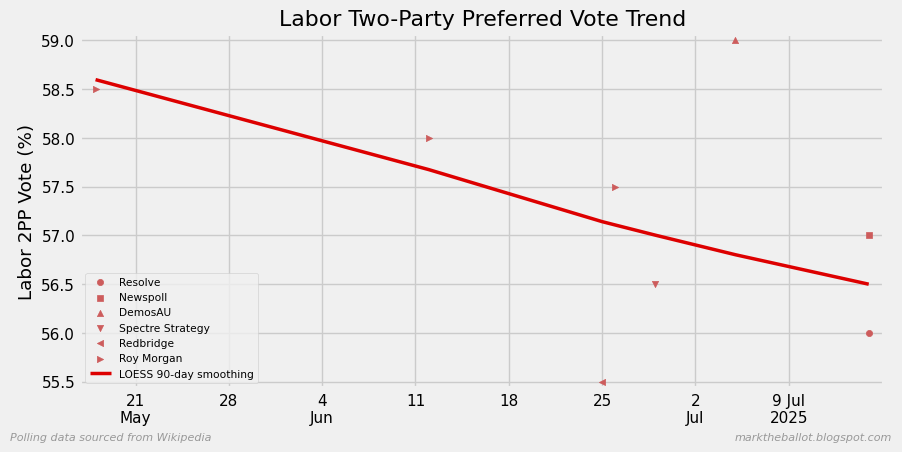

In [8]:
def create_chart_with_loess(df_2pp: pd.DataFrame, smoothed: pd.Series) -> None:
    """Create and display the LOESS chart with polling data."""

    fig, ax = plt.subplots()
    symbols = ['o', 's', '^', 'v', '<', '>', 'D', 'x', 'v']
    for i, label in enumerate(df_2pp['Brand'].unique()):
        selection = df_2pp[df_2pp['Brand'] == label]['2PP vote ALP']
        x = [p.ordinal  for p in selection.index]
        y = selection.to_numpy()
        ax.scatter(x, y, label=label, color=COLOR_LABOR, s=20, marker=symbols[i % len(symbols)])

    mg.line_plot_finalise(
        smoothed,
        ax=ax,
        title="Labor Two-Party Preferred Vote Trend",
        xlabel=None,
        ylabel="Labor 2PP Vote (%)",
        legend=True,
        width=2.5,
        rfooter=RFOOTER,
        lfooter=LFOOTER,
        show=SHOW_PLOT,
    )

# Create and display the chart
create_chart_with_loess(df_2pp, smoothed)

## Finished

In [ ]:
%load_ext watermark
%watermark -t -d -u --python --machine --conda --iversions --watermark

In [ ]:
print("The end.")